In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('LAST_DATA.csv')

In [3]:
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME',inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73957 entries, 2016-01-01 00:20:00 to 2020-03-23 10:20:00
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RUZGARYON     73957 non-null  float64
 1   RUZGARHIZ     73957 non-null  float64
 2   SICKURU       73957 non-null  float64
 3   NISPINEM      73957 non-null  float64
 4   BASINCAKTUEL  73957 non-null  float64
 5   HADISE0       73957 non-null  object 
 6   HADISE1       73957 non-null  object 
 7   GHADISE0      73957 non-null  object 
 8   BLT0CINS      73957 non-null  float64
 9   BLT0YUK       73957 non-null  float64
 10  AY            73957 non-null  int64  
 11  SAAT          73956 non-null  float64
 12  MEVSIM        73956 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 7.9+ MB


In [5]:
numerical_features = ['RUZGARYON', 'RUZGARHIZ', 'SICKURU', 'NISPINEM', 'BASINCAKTUEL', 'BLT0CINS', 'BLT0YUK', 'AY,', 'SAAT,', 'MEVSIM']
categorical_features = ['HADISE0', 'HADISE1', 'GHADISE0']
target_features = ['SICKURU','BASINCAKTUEL','RUZGARHIZ','NISPINEM']

In [7]:
label_encoders = {}

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))


In [8]:
df=df.resample('h').mean()
df=df.ffill()

In [9]:
df.to_csv('final_data.csv')

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53911 entries, 2016-01-01 00:00:00 to 2022-02-24 06:00:00
Freq: h
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RUZGARYON     53911 non-null  float64
 1   RUZGARHIZ     53911 non-null  float64
 2   SICKURU       53911 non-null  float64
 3   NISPINEM      53911 non-null  float64
 4   BASINCAKTUEL  53911 non-null  float64
 5   HADISE0       53911 non-null  float64
 6   HADISE1       53911 non-null  float64
 7   GHADISE0      53911 non-null  float64
 8   BLT0CINS      53911 non-null  float64
 9   BLT0YUK       53911 non-null  float64
 10  AY            53911 non-null  float64
 11  SAAT          53911 non-null  float64
 12  MEVSIM        53911 non-null  float64
dtypes: float64(13)
memory usage: 5.8 MB


(53911, 13)

In [ ]:
shift_days=7
shift_steps= 24*shift_days


In [ ]:
df_targets = df[target_features].shift(-shift_steps)
df_targets.head(5)

,SICKURU,BASINCAKTUEL,RUZGARHIZ,NISPINEM
DATETIME,,,,
2016-01-01 00:00:00,13.3,992.85,2.5,68.0
2016-01-01 01:00:00,13.6,991.65,3.0,57.0
2016-01-01 02:00:00,12.2,991.00,4.0,62.0
2016-01-01 03:00:00,12.3,990.60,5.0,65.5
2016-01-01 04:00:00,12.5,991.10,6.5,67.5


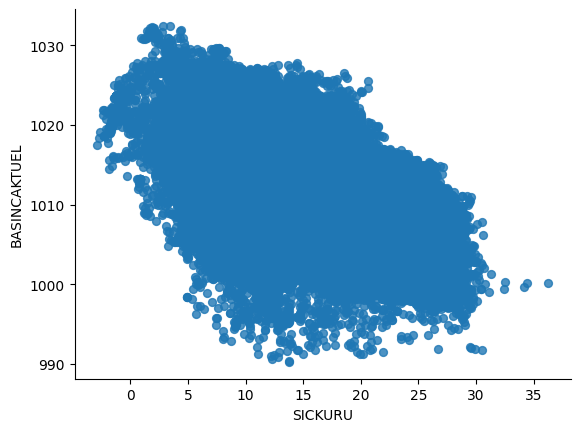

In [ ]:
# @title SICKURU vs BASINCAKTUEL

from matplotlib import pyplot as plt
df_targets.plot(kind='scatter', x='SICKURU', y='BASINCAKTUEL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

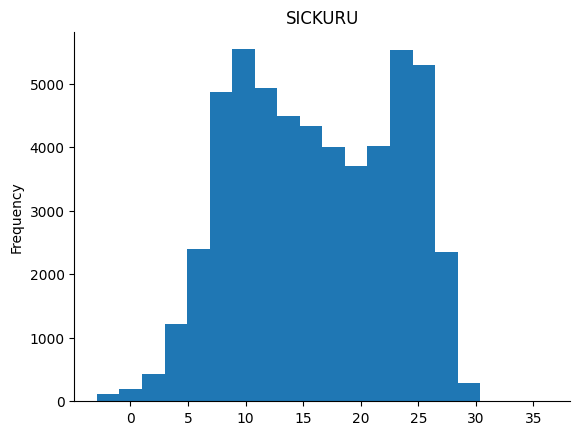

In [ ]:
# @title SICKURU

from matplotlib import pyplot as plt
df_targets['SICKURU'].plot(kind='hist', bins=20, title='SICKURU')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_targets.info()
df_targets.shape


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53911 entries, 2016-01-01 00:00:00 to 2022-02-24 06:00:00
Freq: h
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SICKURU       53743 non-null  float64
 1   BASINCAKTUEL  53743 non-null  float64
 2   RUZGARHIZ     53743 non-null  float64
 3   NISPINEM      53743 non-null  float64
dtypes: float64(4)
memory usage: 2.1 MB


(53911, 4)

In [ ]:
x_data = df.values[0:-shift_steps]

print(type(x_data))
print('Shape: {}'.format(x_data.shape))
x_data

<class 'numpy.ndarray'>
Shape: (53743, 13)


array([[240.  ,   7.  ,  -0.7 , ...,   1.  ,   0.  ,   4.  ],
       [235.  ,   7.5 ,  -0.9 , ...,   1.  ,   1.  ,   4.  ],
       [230.  ,   8.  ,  -0.75, ...,   1.  ,   2.  ,   4.  ],
       ...,
       [119.5 ,   2.5 ,   5.7 , ...,   2.  ,   4.  ,   4.  ],
       [ 49.5 ,   1.  ,   8.  , ...,   2.  ,   5.  ,   4.  ],
       [ 99.  ,   2.  ,   8.6 , ...,   2.  ,   6.  ,   4.  ]])

In [ ]:
y_data = df_targets.values[:-shift_steps]
print('Shape: {}'.format(y_data.shape))

Shape: (53743, 4)


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)

In [ ]:
# MinMaxScaler kullanarak verileri ölçeklendir
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hedef değişkenleri de ölçeklendir
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print("Ölçeklendirilmiş veri şekilleri:")
print("X_train:", X_train_scaled.shape)
print("X_val:", X_val_scaled.shape)
print("X_test:", X_test_scaled.shape)
print("y_train:", y_train_scaled.shape)
print("y_val:", y_val_scaled.shape)
print("y_test:", y_test_scaled.shape)

Ölçeklendirilmiş veri şekilleri:
X_train: (34395, 13)
X_val: (8599, 13)
X_test: (10749, 13)
y_train: (34395, 4)
y_val: (8599, 4)
y_test: (10749, 4)


In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating a Random Batches of Training-data
    """

    # Infinite loop (!)
    while True:
        # Allocate a new array for the batch of Input-signals.
        x_shape = (batch_size, sequence_length, x_data.shape[1])
        x_batch = np.zeros(shape = x_shape, dtype = np.float16)

        # Allocate a new array for the batch of Output-signals.
        y_shape = (batch_size, sequence_length, y_data.shape[1])
        y_batch = np.zeros(shape = y_shape, dtype = np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a randon start-index
            # This points somewhere into the training-data
            idx = np.random.randint(X_train_scaled.shape[0] - sequence_length)

            # Copy the sequence of data starting at this index
            x_batch[i] = X_train_scaled[idx : idx + sequence_length]
            y_batch[i] = y_train_scaled[idx : idx + sequence_length]

        yield(x_batch, y_batch)

In [ ]:
  sequence_length = 24 * 7
  batch_size = 32
  generator = batch_generator(batch_size = batch_size, sequence_length = sequence_length)

In [ ]:
x_batch, y_batch = next(generator)
print("X_batch:", x_batch.shape)
print("y_batch:", y_batch.shape)

X_batch: (32, 168, 13)
y_batch: (32, 168, 4)


In [ ]:
# Model mimarisini güncelle
model = Sequential([
    LSTM(128, input_shape=(sequence_length, x_data.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),  # return_sequences=True ekledik
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_data.shape[1])  # Her zaman adımı için tahmin
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mae'])

In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 128)            │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 168, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 168, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 168, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 168, 4)              │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,324 (485.64 KB)

 Trainable params: 124,324 (485.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        verbose = 1)

In [ ]:
path_checkpoint = '23_checkpoint.weights.h5'
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                      monitor = 'val_loss',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_best_only = True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir = './23_logs/',
                                   histogram_freq = 0,
                                   write_graph = False)

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                       factor = 0.1,
                                       min_lr = 1e-4,
                                       patience = 0,
                                       verbose = 1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
# Batch generator'ı oluştur
sequence_length = 24 * 7  # 7 günlük veri
batch_size = 32
generator = batch_generator(batch_size, sequence_length)

# Model eğitimini generator ile yap
history = model.fit(
    generator,
    steps_per_epoch=len(X_train_scaled) // batch_size,
    epochs=50,
    validation_data=generator,  # Validation için de generator kullan
    validation_steps=len(X_val_scaled) // batch_size,
    callbacks = callbacks,
    verbose=1
)



Epoch 1/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.0272 - mae: 0.1207
Epoch 1: val_loss improved from inf to 0.01702, saving model to 23_checkpoint.weights.h5
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 414s 380ms/step - loss: 0.0272 - mae: 0.1206 - val_loss: 0.0170 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 2/50
 169/1074 ━━━━━━━━━━━━━━━━━━━━ 5:08 341ms/step - loss: 0.0179 - mae: 0.0990

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

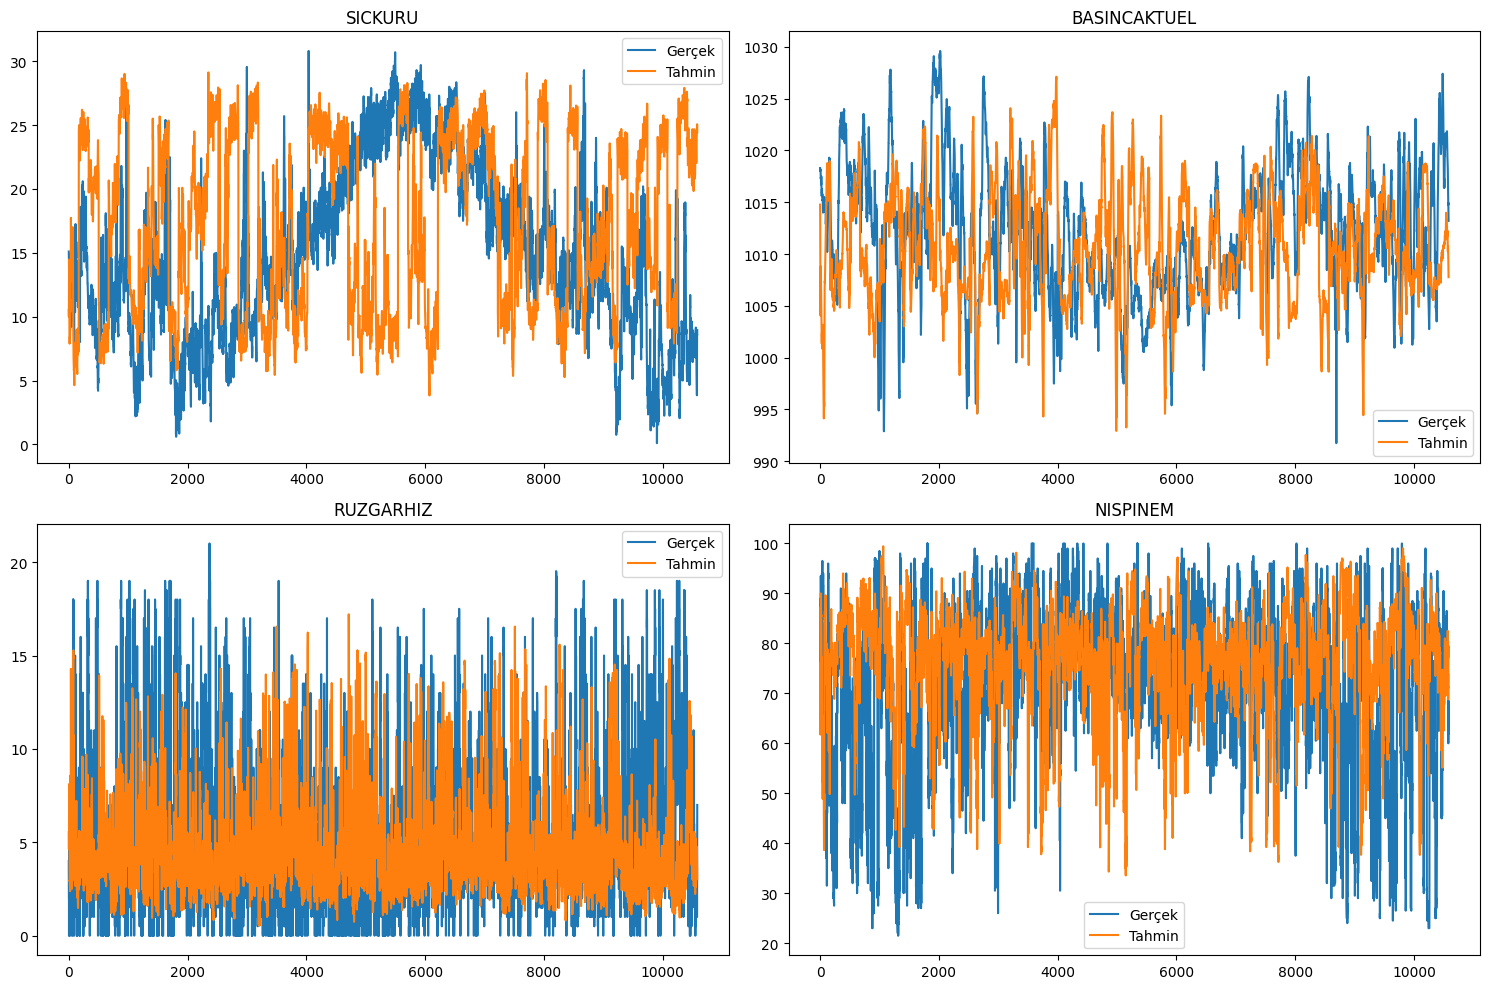

In [ ]:
# Test seti üzerinde tahmin yap
# Test verisini batch generator ile hazırlayın
test_generator = batch_generator(batch_size=1, sequence_lenght=sequence_length)

# Tahminleri toplamak için bir liste oluşturun
y_pred_list = []

# Test seti boyunca tahmin yap
for _ in range(len(X_test_scaled) // sequence_length):
    x_test_batch, _ = next(test_generator)
    y_pred = model.predict(x_test_batch)
    y_pred_list.append(y_pred)

# Tahminleri birleştirin
y_pred_combined = np.concatenate(y_pred_list, axis=0)

# Tahminleri orijinal ölçeğe geri dönüştür
y_pred_original = scaler_y.inverse_transform(y_pred_combined.reshape(-1, y_data.shape[1]))
y_test_original = scaler_y.inverse_transform(y_test_scaled[:len(y_pred_original)].reshape(-1, y_data.shape[1]))

# Her hedef özellik için grafik çiz
plt.figure(figsize=(15, 10))
for i, feature in enumerate(target_features):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_original[:, i], label='Gerçek')
    plt.plot(y_pred_original[:, i], label='Tahmin')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()

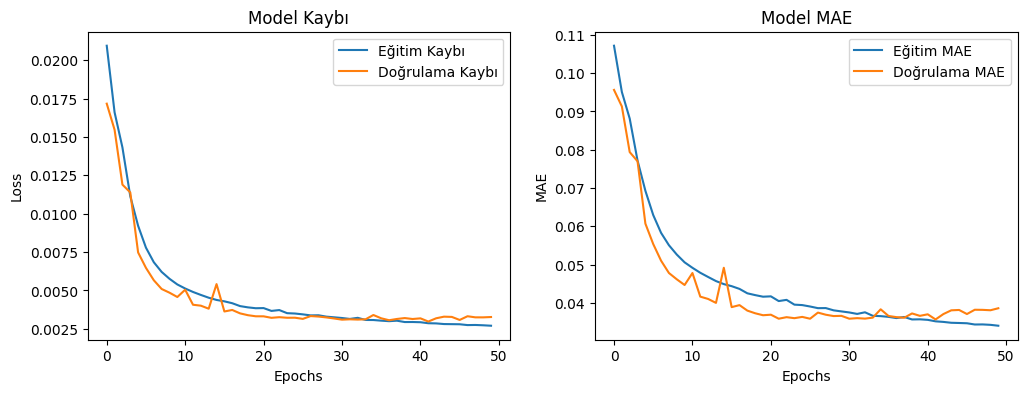

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Doğrulama MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

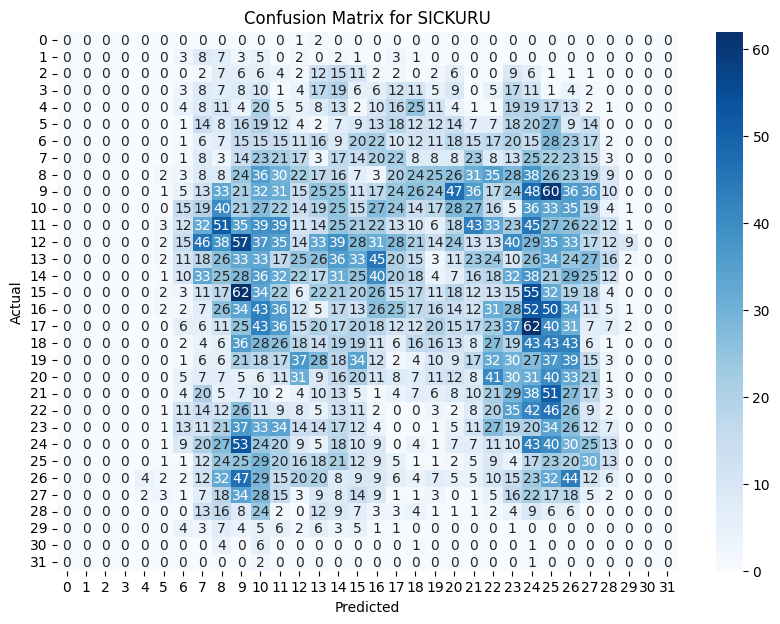

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming the first target feature is categorical for confusion matrix
y_test_categorical = np.round(y_test_original[:, 0]).astype(int)
y_pred_categorical = np.round(y_pred_original[:, 0]).astype(int)

conf_matrix = confusion_matrix(y_test_categorical, y_pred_categorical)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for ' + target_features[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

accuracy = accuracy_score(y_test_categorical, y_pred_categorical)
recall = recall_score(y_test_categorical, y_pred_categorical, average='macro')
f1 = f1_score(y_test_categorical, y_pred_categorical, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.0411
Recall: 0.0313
F1 Score: 0.0282


In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print('Error trying to load checkpoint.\n{}'.format(error))